In [ ]:
# https://dacon.io/codeshare/1822?fbclid=IwAR27Sx1AFrddZ5M-R1NSrLV9QO2vSS4-Ibd91zjT5MYzTt5w9qNibWPcNbE 참고

In [1]:

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import string
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
from pathlib import Path
import pandas as pd
from nltk.tokenize import TweetTokenizer
import re
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
# Tweet tokenizer does not split at apostophes which is what we want 
from nltk.tokenize import TweetTokenizer 
from nltk.tokenize import word_tokenize  
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import warnings

In [3]:

rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
warnings.simplefilter('ignore')

In [4]:
data_dir = Path('../input/')
trn_file = data_dir / 'train.csv'
tst_file = data_dir / 'test_x.csv'

seed = 42

In [7]:
trn = pd.read_csv(trn_file, index_col=0)
print(trn.shape)
trn.head()

(54879, 2)


,text,author
index,,
0,"He was almost choking. There was so much, so m...",3
1,"“Your sister asked for it, I suppose?”",2
2,"She was engaged one day as she walked, in per...",1
3,"The captain was in the porch, keeping himself ...",4
4,"“Have mercy, gentlemen!” odin flung up his han...",3


In [9]:
tst = pd.read_csv(tst_file, index_col=0)
print(tst.shape)
tst.head()

(19617, 1)


,text
index,
0,“Not at all. I think she is one of the most ch...
1,"""No,"" replied he, with sudden consciousness, ""..."
2,As the lady had stated her intention of scream...
3,“And then suddenly in the silence I heard a so...
4,His conviction remained unchanged. So far as I...


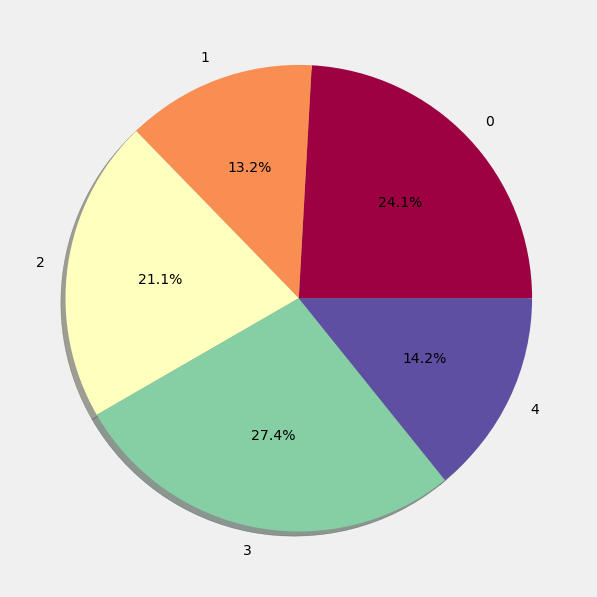

In [8]:
import numpy as np

temp = trn.groupby(['author']).count().reset_index()
temp.columns = ['author', 'count']
size = list(temp['count'])

source_labels = temp['author']
source_counts = temp['count']

# Make square figures and axes
plt.figure(1, figsize=(20,10))

cmap = plt.get_cmap('Spectral')
colors = [cmap(i) for i in np.linspace(0, 1, 5)]
source_pie = plt.pie(source_counts, labels=source_labels, autopct='%1.1f%%', shadow=True, colors=colors)

plt.show()

#0번과 3번 2번이 비중이 많음

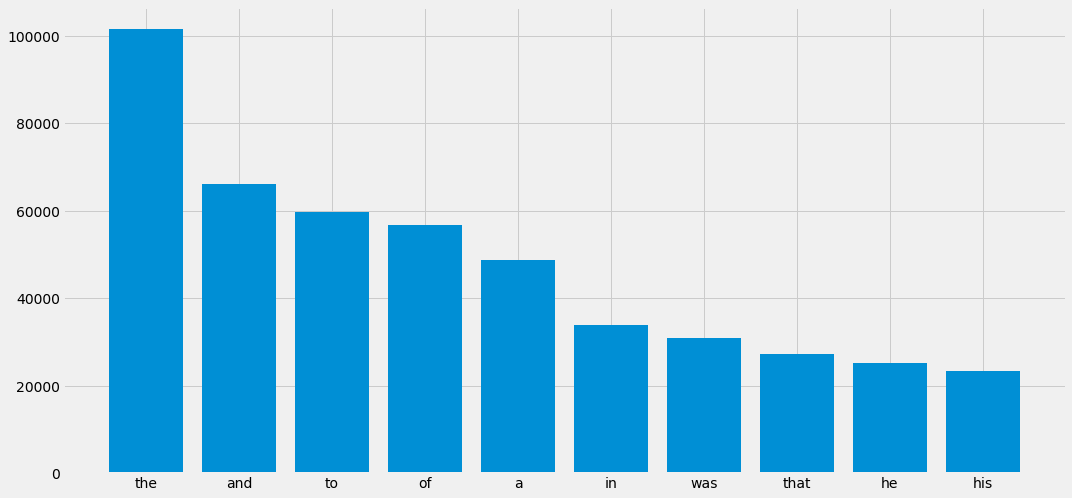

In [13]:
from collections import defaultdict

def plot_top_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]
    dic=defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word]+=1
            
    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    x,y=zip(*top)
    plt.bar(x,y)

plot_top_stopwords_barchart(trn['text'])   
#train에서 많이나오는 stopword들 삭제??

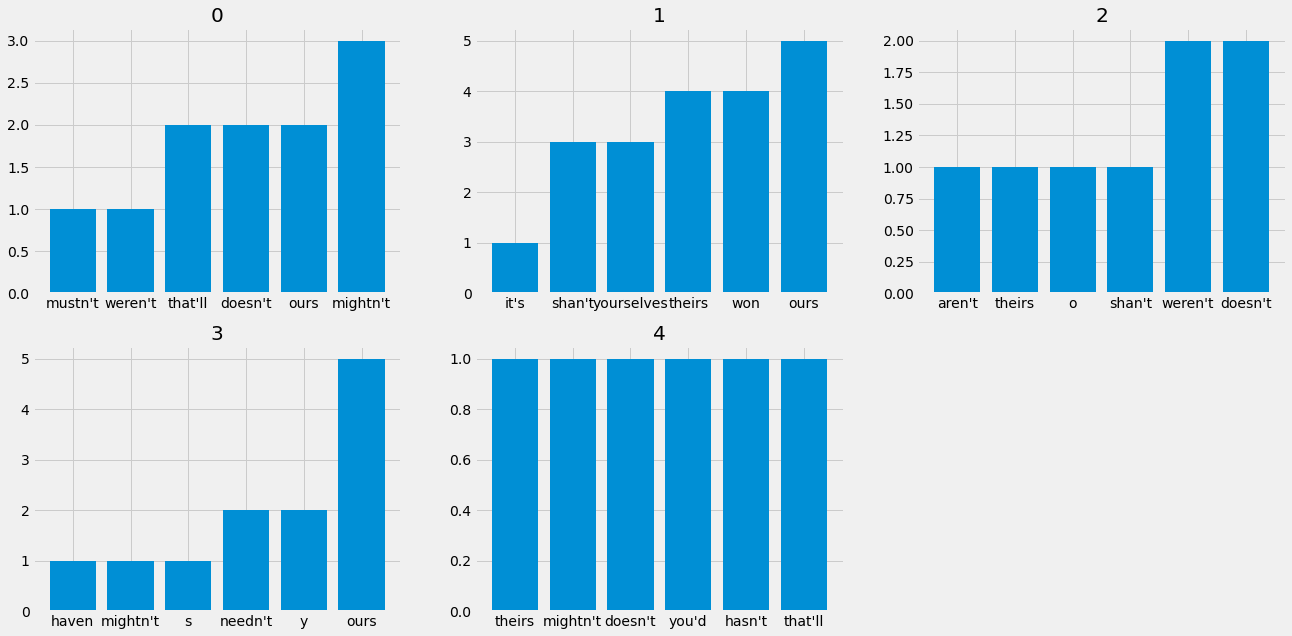

In [20]:
fig = plt.figure(figsize=(20,10)) # rows*cols 행렬의 i번째 subplot 생성
rows = 2
cols = 3
i = 1

def plot_top_stopwords_barchart2(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]
    from collections import defaultdict
    dic=defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word]+=1
            
    top=sorted(dic.items(), key=lambda x:x[1],reverse=False)[:6] 
    x,y=zip(*top)
    return x, y

for i in range(5):
    x,y = plot_top_stopwords_barchart2(trn[trn['author']==i]['text'])
    ax = fig.add_subplot(rows, cols, i+1)
    ax.set_title(i)
    ax.bar(x,y)

#공통적으로 1번에 her이 많고 3번에 you가 많음.
#reverse=False일때 1번과 2번 4번에 theirs 나타남 얘는 지우자.

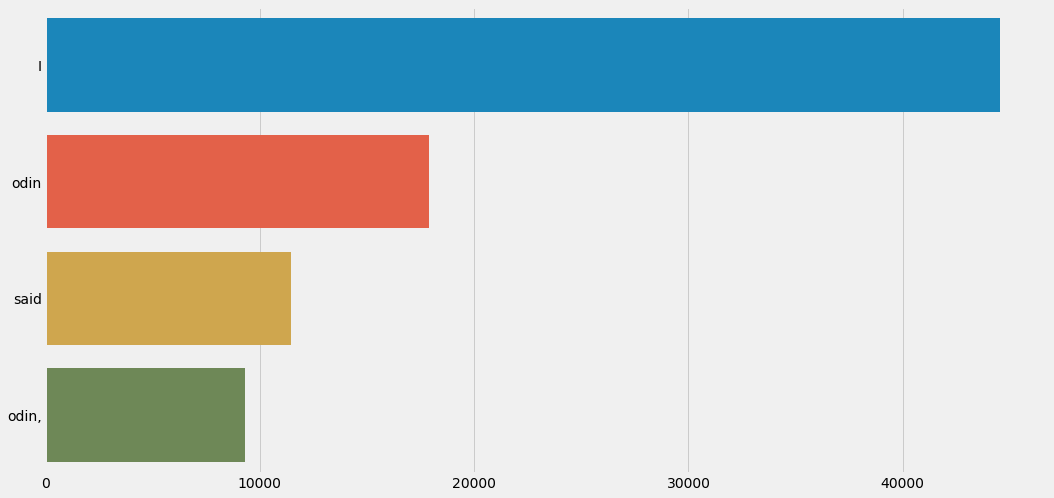

In [22]:
import seaborn as sns
from nltk.corpus import stopwords
from collections import  Counter

def plot_top_non_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:40]:
        if (word not in stop):
            x.append(word)
            y.append(count)
            
    sns.barplot(x=y,y=x)

plot_top_non_stopwords_barchart(trn['text'])



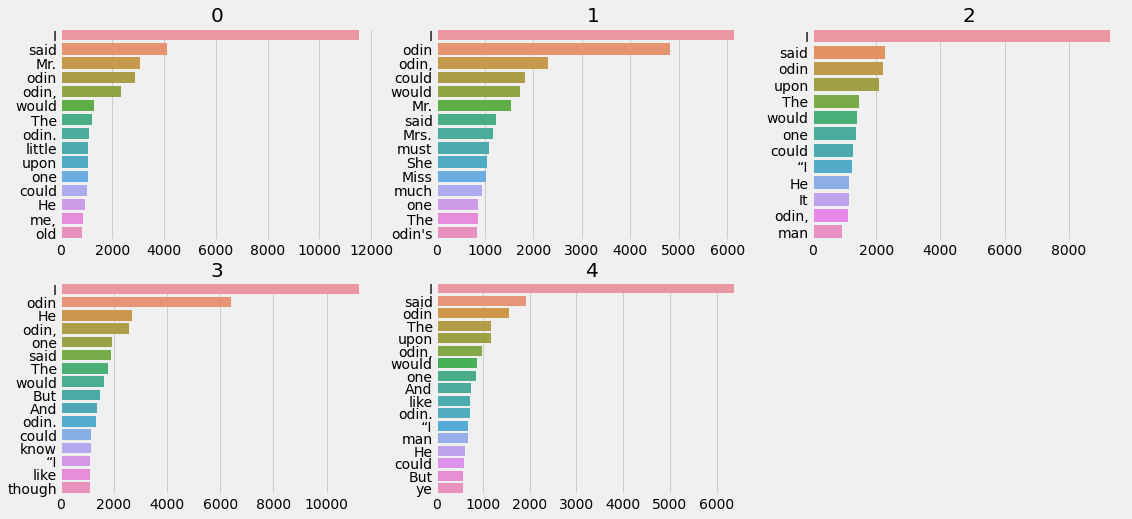

In [25]:
fig = plt.figure(figsize=(17,8)) # rows*cols 행렬의 i번째 subplot 생성
rows = 2
cols = 3

def plot_top_non_stopwords_barchart2(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:70]:
        if (word not in stop):
            x.append(word)
            y.append(count)
    return x, y

for i in range(5):
    x,y = plot_top_non_stopwords_barchart2(trn[trn['author']==i]['text'])
    ax = fig.add_subplot(rows, cols, i+1)
    ax.set_title(i)
    sns.barplot(x=y,y=x)
    
# 0번과 1번에서 Mr. 많이나옴.
# I,odin, odin.은 삭제

In [26]:
trn['text_l'] = trn['text'].str.lower() 
tst['text_l'] = tst['text'].str.lower() 

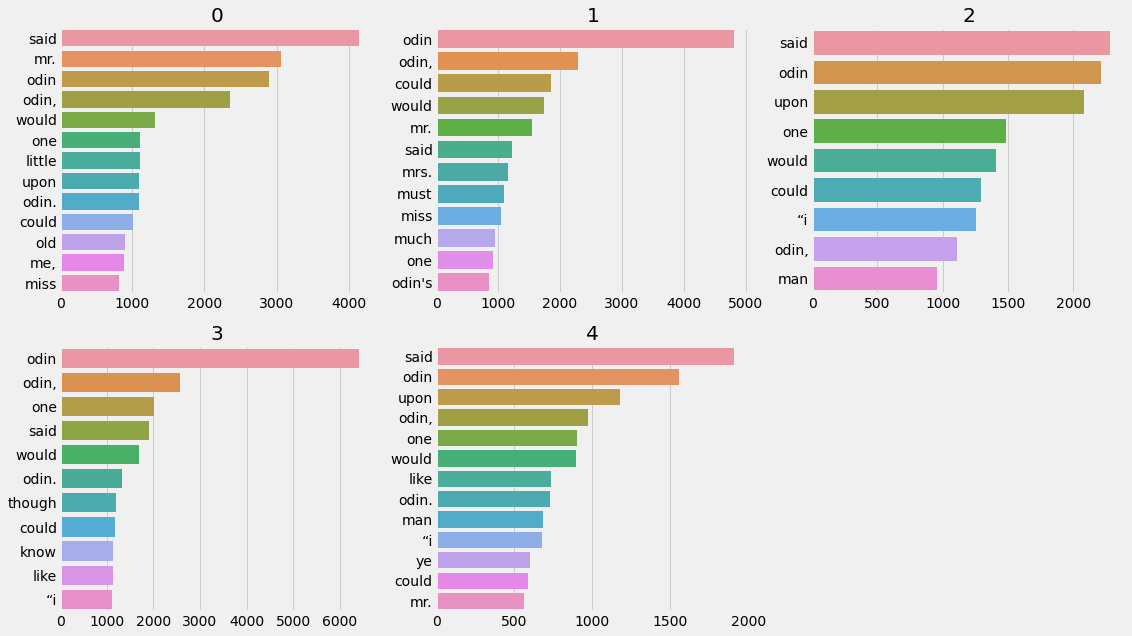

In [27]:
fig = plt.figure(figsize=(17,10)) # rows*cols 행렬의 i번째 subplot 생성
rows = 2
cols = 3


def plot_top_non_stopwords_barchart3(text):
    stop=set(stopwords.words('english'))
    #stop.add(('odin', 'odin,', 'odin.'))

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:70]:
        if (word not in stop):
            x.append(word)
            y.append(count)
    return x, y

for i in range(5):
    x,y = plot_top_non_stopwords_barchart3(trn[trn['author']==i]['text_l'])
    ax = fig.add_subplot(rows, cols, i+1)
    ax.set_title(i)
    sns.barplot(x=y,y=x)
    
#0번에 miss mr 많음.    

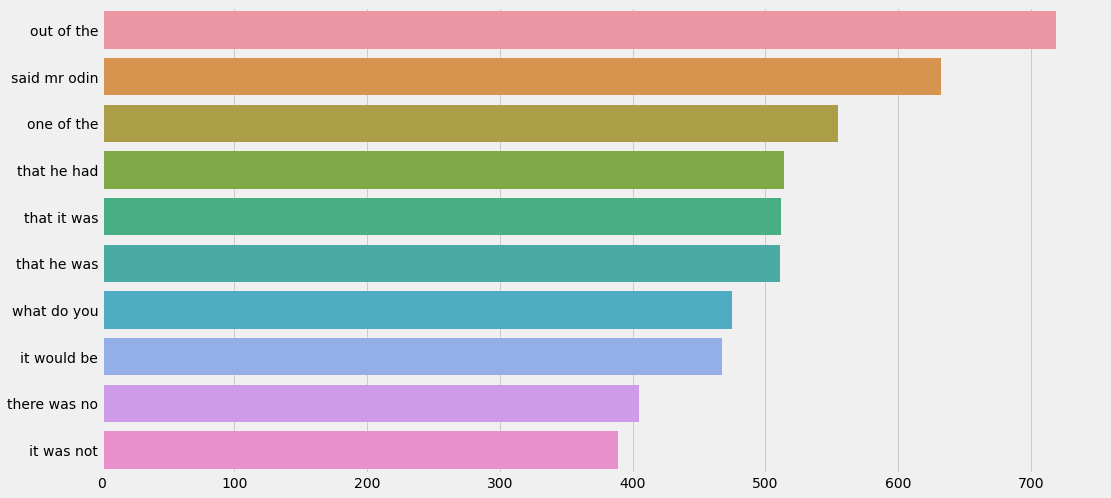

In [28]:
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import  Counter

def plot_top_ngrams_barchart(text, n=2):
    stop=set(stopwords.words('english'))

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:10]

    top_n_bigrams=_get_top_ngram(text,n)[:10]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x)

plot_top_ngrams_barchart(trn['text'], n=3)  

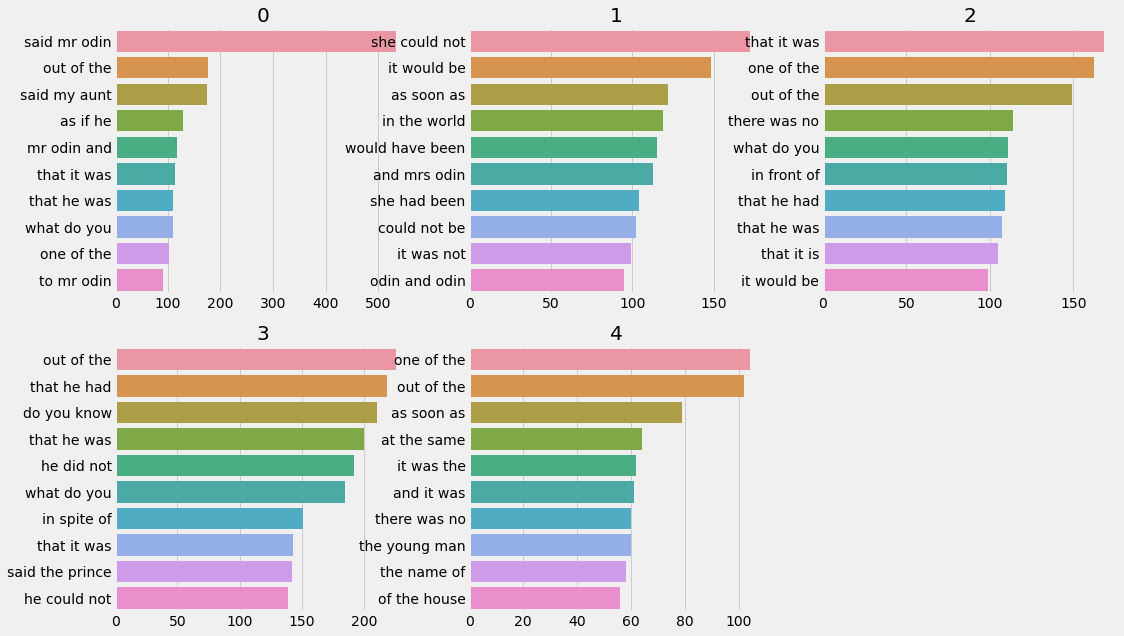

In [29]:
fig = plt.figure(figsize=(16,10)) # rows*cols 행렬의 i번째 subplot 생성
rows = 2
cols = 3

def plot_top_ngrams_barchart2(text, n=2):
    stop=set(stopwords.words('english'))

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:10]

    top_n_bigrams=_get_top_ngram(text,n)[:10]
    x,y=map(list,zip(*top_n_bigrams))
    
    return x, y

for i in range(5):
    x,y = plot_top_ngrams_barchart2(trn[trn['author']==i]['text_l'], n=3)
    ax = fig.add_subplot(rows, cols, i+1)
    ax.set_title(i)
    sns.barplot(x=y,y=x)

In [37]:
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.stem.wordnet import WordNetLemmatizer 

nltk.download('stopwords')
stop=set(stopwords.words('english'))

def plot_wordcloud(text):
    

    def _preprocess_text(text):
        corpus=[]
        #stem=PorterStemmer()
        lem=WordNetLemmatizer()
        for news in text:
            words=[w for w in word_tokenize(news) if (w not in stop)]

            words=[lem.lemmatize(w) for w in words if len(w)>2]

            corpus.append(words)
        return corpus
    
    corpus=_preprocess_text(text)
    
    wordcloud = WordCloud(
        background_color='white',
        stopwords=set(STOPWORDS),
        max_words=100,
        max_font_size=30, 
        scale=3,
        random_state=1)
    
    wordcloud=wordcloud.generate(str(corpus))
    
    return wordcloud

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/cksgnlcjswo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


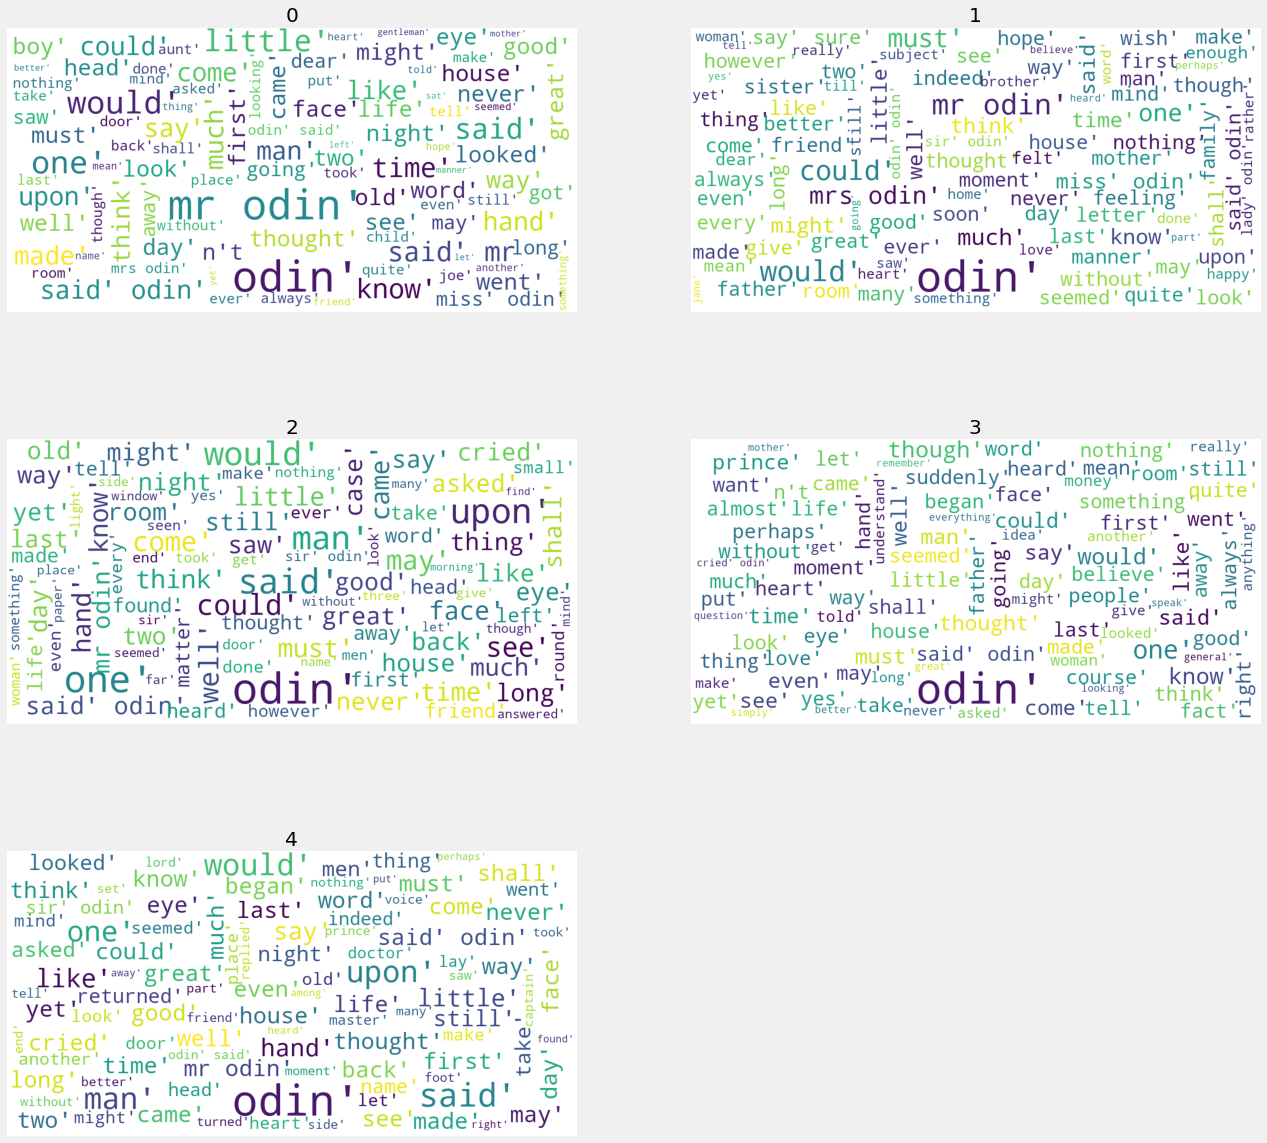

In [38]:
fig = plt.figure(figsize=(20,20)) # rows*cols 행렬의 i번째 subplot 생성
rows = 3
cols = 2

for i in range(5):
    wordcloud = plot_wordcloud(trn[trn['author']==i]['text_l'])
    ax = fig.add_subplot(rows, cols, i+1)
    
    #fig = plt.figure(1, figsize=(12, 12))
    ax.axis('off')
    ax.set_title(i)
    ax.imshow(wordcloud)
  

In [41]:
import nltk
nltk.download('averaged_perceptron_tagger')

def plot_wordcloud_noun(text,tags=['NN','NNP']):
    

    def _preprocess_text(text,tags):
        corpus=[]
       # stem=PorterStemmer()
        lem=WordNetLemmatizer()
        for news in text:
            words=[w for w in word_tokenize(news) if (w not in stop)]
            words=[lem.lemmatize(w) for w in words if len(w)>2]
            
            tagged = nltk.pos_tag(words)
            allnoun = [word for word, pos in tagged if pos in tags]

            corpus.append(allnoun)
        return corpus
    
    corpus=_preprocess_text(text,tags)
    
    wordcloud = WordCloud(
        background_color='white',
        stopwords=set(STOPWORDS),
        max_words=100,
        max_font_size=30, 
        scale=3,
        random_state=1)
    
    wordcloud=wordcloud.generate(str(corpus))
    
    return wordcloud

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/cksgnlcjswo/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


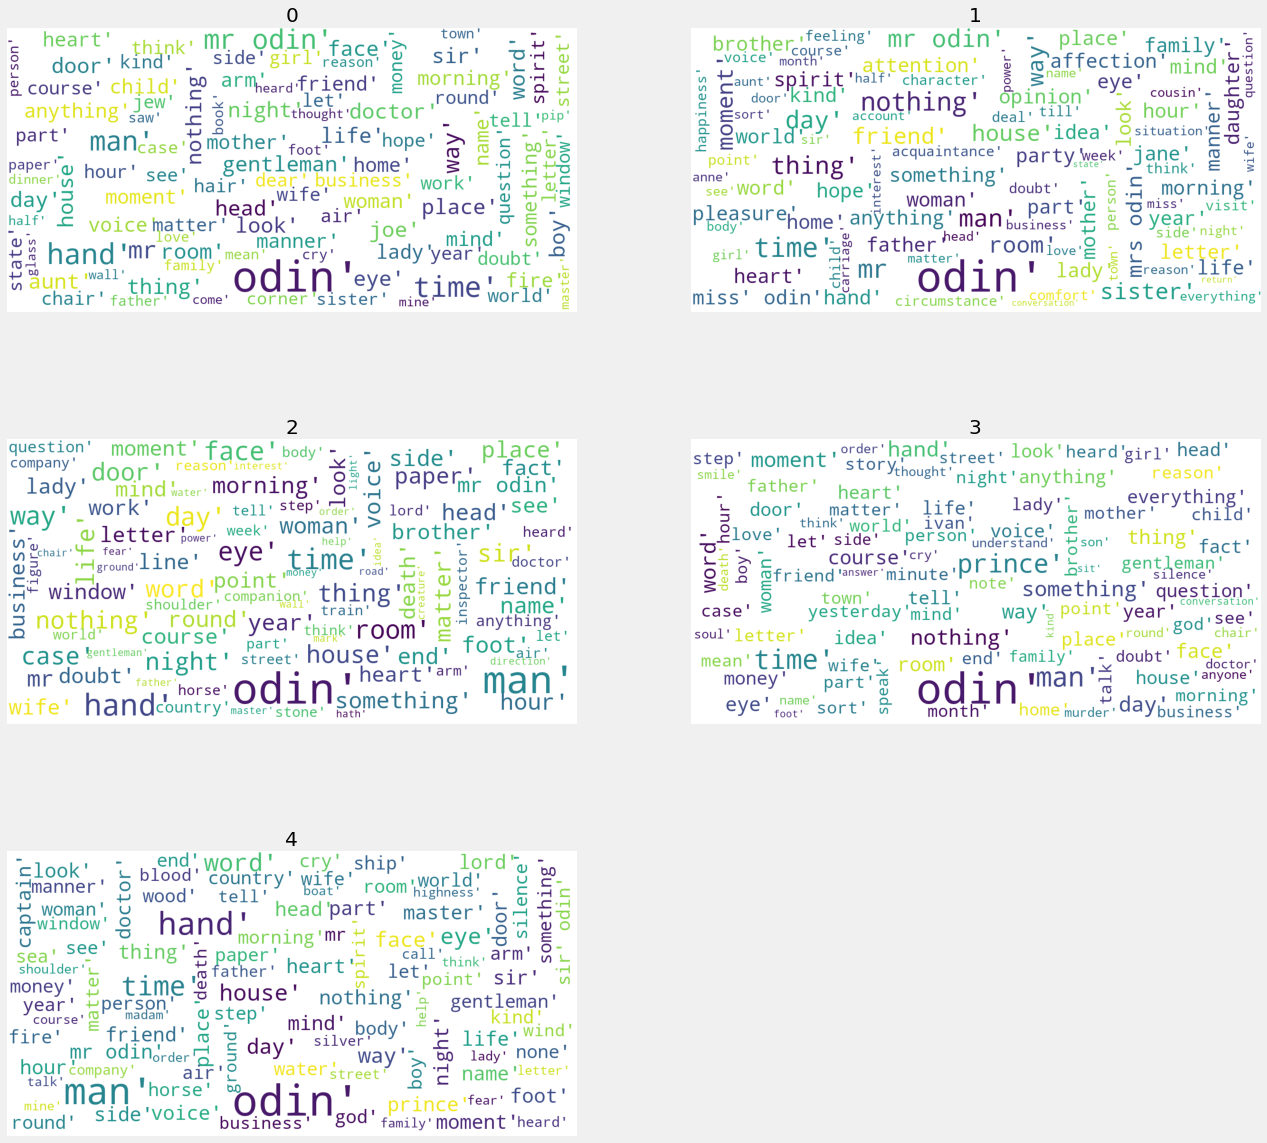

In [42]:
fig = plt.figure(figsize=(20,20)) # rows*cols 행렬의 i번째 subplot 생성
rows = 3
cols = 2

for i in range(5):
    wordcloud = plot_wordcloud_noun(trn[trn['author']==i]['text_l'], ['NN','NNP'])
    ax = fig.add_subplot(rows, cols, i+1)
    ax.axis('off')
    ax.set_title(i)
    ax.imshow(wordcloud)

#odin, thing, nothing

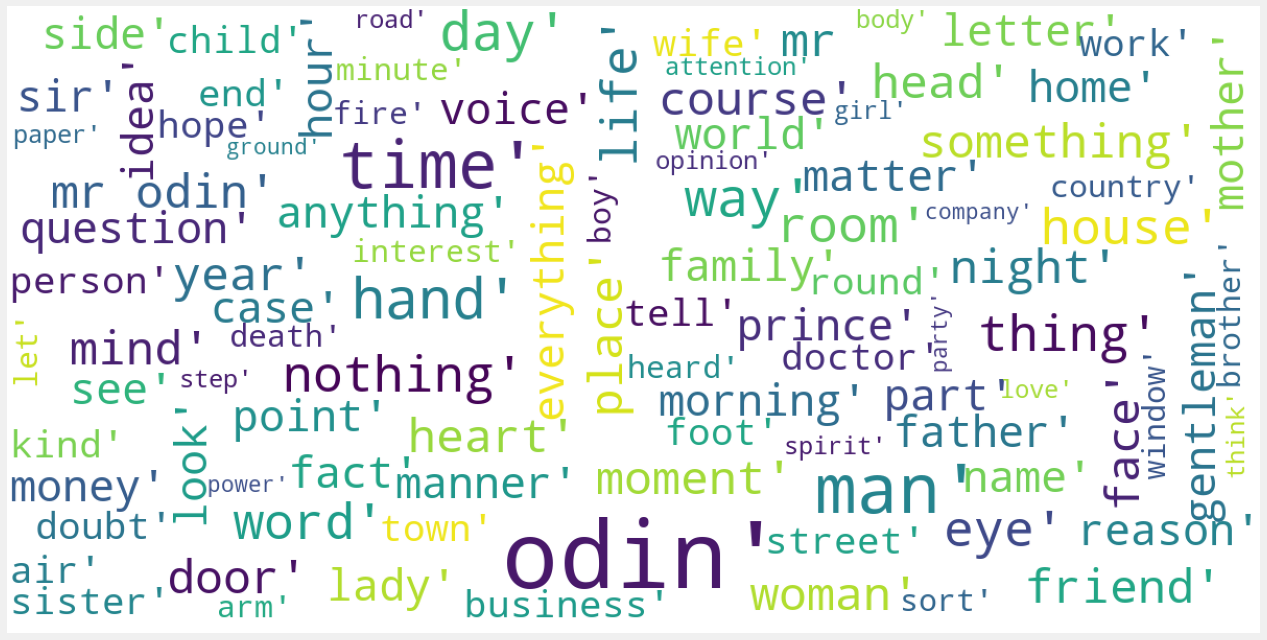

In [43]:
wordcloud = plot_wordcloud_noun(tst['text_l'])
fig, ax = plt.subplots(figsize=(20, 15))
ax.axis('off')
ax.imshow(wordcloud)

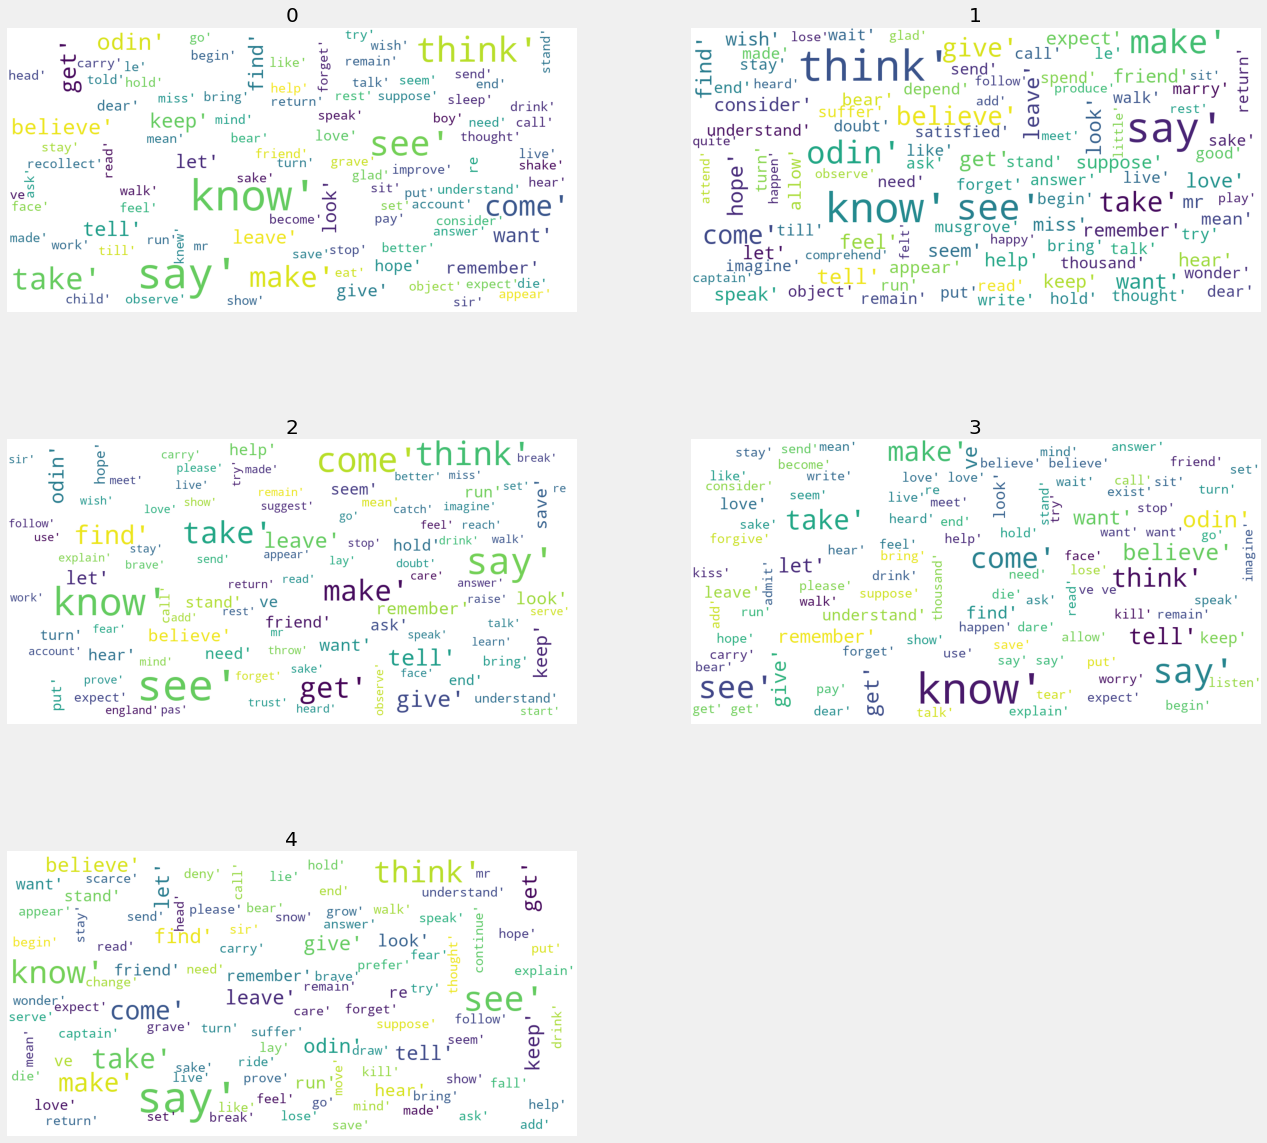

In [45]:
fig = plt.figure(figsize=(20,20)) # rows*cols 행렬의 i번째 subplot 생성
rows = 3
cols = 2

for i in range(5):
    wordcloud = plot_wordcloud_noun(trn[trn['author']==i]['text_l'], ['VB','VBP'])
    ax = fig.add_subplot(rows, cols, i+1)
    ax.axis('off')
    ax.set_title(i)
    ax.imshow(wordcloud)

#think know say see가 공통적으로 많이나와서 삭제 필요해보임

In [ ]:
wordcloud = plot_wordcloud_noun(test['text_l'], ['VB','VBP'])

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.axis('off')
ax.imshow(wordcloud)

In [ ]:
from textblob import TextBlob
TextBlob('100 people killed in Iraq').sentiment

In [ ]:
from textblob import TextBlob
    
def plot_polarity_histogram(text):
    
    def _polarity(text):
        return TextBlob(text).sentiment.polarity
        
    polarity_score = text.apply(lambda x : _polarity(x))
    return polarity_score

In [ ]:
fig = plt.figure(figsize=(20,5)) # rows*cols 행렬의 i번째 subplot 생성
rows = 1
cols = 5

for i in range(5):
    polarity_score = plot_polarity_histogram(trn[trn['author']==i]['text_l'])
    ax = fig.add_subplot(rows, cols, i+1)
    ax.set_title(i)
    polarity_score.hist()

In [ ]:
polarity_score = plot_polarity_histogram(test['text_l'])
polarity_score.hist()

In [ ]:
import spacy
from collections import  Counter
import seaborn as sns

def plot_named_entity_barchart(text):
    nlp = spacy.load("en_core_web_sm")
    
    def _get_ner(text):
        doc=nlp(text)
        return [X.label_ for X in doc.ents]
    
    ent=text.apply(lambda x : _get_ner(x))
    ent=[x for sub in ent for x in sub]
    counter=Counter(ent)
    count=counter.most_common()
    
    x,y=map(list,zip(*count))
    return x,y

In [ ]:
fig = plt.figure(figsize=(20,20)) # rows*cols 행렬의 i번째 subplot 생성
rows = 2
cols = 3

for i in range(5):
    x, y = plot_named_entity_barchart(train[train['author']==i]['text_l'])
    ax = fig.add_subplot(rows, cols, i+1)
    ax.set_title(i)
    sns.barplot(x=y,y=x)
#사람관련이 많고, 시간, 날짜 관련이 많음
# 3번은 cardinal이 제일 많은데 숫자를 지우는것보다 적절히 표현하면 될듯